# Implementing MobileNet
https://arxiv.org/pdf/1704.04861.pdf

Define global constants

In [1]:
BASE_PATH = !pwd
TF_MODEL_PATH = BASE_PATH[0] + '/tensorflow/'
TRAIN_DATA_PATH = BASE_PATH[0] + '/train_data/'
WEIGHTS_PATH = BASE_PATH[0] + '/model_weights.h5'
CLASSES_PATH = BASE_PATH[0] + '/classes_def.json'
CHECKPOINT_PATH = BASE_PATH[0] + '/weights-{epoch:02d}-{loss:.4f}.h5'
FULL_MODEL_PATH = BASE_PATH[0] + '/full_model.h5'
LOG_DIR = BASE_PATH[0] + '/logs/'

Utility functions to gather training data

In [2]:
import cv2
import numpy as np
from os import path, listdir
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from tqdm import tqdm
import sys

MAX_CONTOURS = 30
IMAGE_SIZE = (1600, 900)
EPSILON_RATIO = 0.03

# Define the card size - also input of the NN model
TARGET_SIZE = (224, 224)

class ImageFile:
    def __init__(self, file_name):
        self.file_name = file_name
        self.file_data = cv2.imread(file_name)
        
        if (self.file_data.shape[0] > self.file_data.shape[1]):
            self.file_data = cv2.resize(self.file_data, (IMAGE_SIZE[1], IMAGE_SIZE[0]))
        else:
            self.file_data = cv2.resize(self.file_data, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
        
        self.file_data = cv2.cvtColor(self.file_data, cv2.COLOR_BGR2RGB)
        
    def preprocess(self):
        output = cv2.cvtColor(self.file_data, cv2.COLOR_BGR2GRAY)
        output = cv2.bilateralFilter(output,9,75,75)
        output = cv2.adaptiveThreshold(output,
            255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        output = cv2.Laplacian(output, cv2.CV_64F)
        output = np.absolute(output)
        output = np.uint8(output)

        return output

    def find_cards(self, preprocessed_img):
        dummy, contours, hierachy = cv2.findContours(preprocessed_img, 
            cv2.RETR_TREE, 
            cv2.CHAIN_APPROX_SIMPLE)
        contour_areas = [cv2.contourArea(cnt) for cnt in contours]
        
        index_sort = sorted(range(len(contours)), 
            key=lambda idx : contour_areas[idx], 
            reverse=True)
        
        if MAX_CONTOURS is not None and len(index_sort) > MAX_CONTOURS:
            index_sort = index_sort[:MAX_CONTOURS]
            
        for idx in index_sort:
            peri = cv2.arcLength(contours[idx], True)
            approx = cv2.approxPolyDP(contours[idx], EPSILON_RATIO * peri, True)
            
            if len(approx) == 4 and hierachy[0][idx][3] == -1:
                yield approx
    
    def get_card_data(self, contour):
        x, y, width, height = cv2.boundingRect(contour)
        
        points = contour.reshape(4, 2)
        
        sum_pts = np.sum(points, axis=1)
        tl = points[np.argmin(sum_pts)]
        br = points[np.argmax(sum_pts)]

        diff_pts = np.diff(points, axis=1)
        tr = points[np.argmin(diff_pts)]
        bl = points[np.argmax(diff_pts)]
        
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        
        maxWidth = int(max(widthA, widthB))
        maxHeight = int(max(heightA, heightB))
        
        destination = np.array([
                [0, 0],
                [maxWidth - 1, 0],
                [maxWidth - 1, maxHeight - 1],
                [0, maxHeight - 1]
            ], dtype = 'float32')
        
        rect = np.zeros((4, 2), dtype = "float32")
        rect[0] = tl
        rect[1] = tr
        rect[2] = br
        rect[3] = bl
        
        perspective_transform = cv2.getPerspectiveTransform(rect, destination)
        
        warped_img = cv2.warpPerspective(self.file_data, perspective_transform, (maxWidth, maxHeight))
        
        if maxWidth > 1.1 * maxHeight:
            warped_img = self.rotate_image(warped_img, 90)
        
        return {
            'x': x,
            'y': y,
            'img': warped_img
        }
    
    def rotate_image(self, img_data, angle):
        rows, cols, channels = img_data.shape
        (cX, cY) = (cols // 2, rows // 2)
        
        rotation_matrix = cv2.getRotationMatrix2D((cX, cY), angle, 1)
        
        cos = np.abs(rotation_matrix[0, 0])
        sin = np.abs(rotation_matrix[0, 1])
        nW = int((rows * sin) + (cols * cos))
        nH = int((rows * cos) + (cols * sin))
        rotation_matrix[0, 2] += (nW / 2) - cX
        rotation_matrix[1, 2] += (nH / 2) - cY
        
        return cv2.warpAffine(img_data, rotation_matrix, (nW, nH))
    
    def extract_cards(self, resize=None):
        img_data = self.preprocess()
        contours = self.find_cards(img_data)
        
        for contour in contours:
            data = self.get_card_data(contour)
            if resize is not None:
                data['img'] = cv2.resize(data['img'], resize)
            yield data

def plot_image(img_data):
    plt.imshow(img_data)
    plt.axis('off')  # to hide the axes
    plt.show()
    
def get_training_files():
    labels = []
    images = []
    
    for label_dir in [item for item in listdir(TRAIN_DATA_PATH) if path.isdir(TRAIN_DATA_PATH + item)]:
        full_dir = TRAIN_DATA_PATH + label_dir + '/'
        for train_file in [item for item in listdir(full_dir) if path.isfile(full_dir + item)]:
            images.append(full_dir + train_file)
            labels.append(label_dir)

    classes = list(set(labels))
    print('number of classes %s, number of files %s' % (len(classes), len(images)))
    
    return {
        'labels': labels,
        'images': images,
        'classes': classes
    }

def get_training_data(data = None):
    if data is None:
        data = get_training_files()
    
    labels = data['labels']
    images = data['images']
    classes = data['classes']
    
    num_classes = len(classes)
    
    for idx, image in enumerate(images):
        # take the first card found
        image_file = next(ImageFile(image) \
            .extract_cards(resize=TARGET_SIZE), None)
        if image_file is not None:
            image_file = image_file['img']
            label = to_categorical(classes.index(labels[idx]), num_classes=num_classes)
            yield (image_file, label)
        else:
            print('Warning: Card not found in file %s' % image)

/Users/2359media/anaconda/envs/yolo-keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/2359media/anaconda/envs/yolo-keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Testing the data extraction function:

number of classes 4, number of files 20


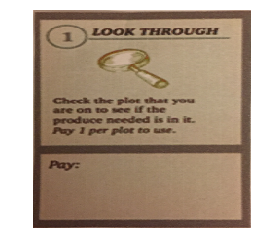

[0. 0. 1. 0.]


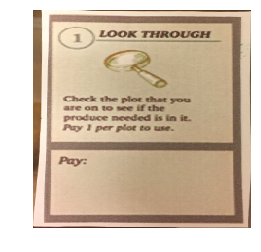

[0. 0. 1. 0.]


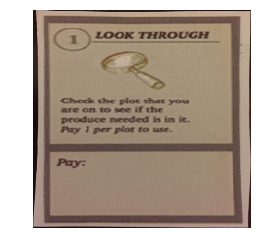

[0. 0. 1. 0.]


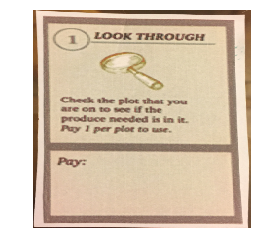

[0. 0. 1. 0.]


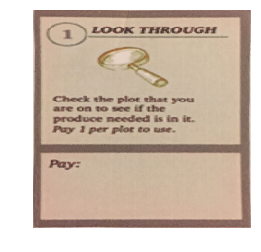

[0. 0. 1. 0.]


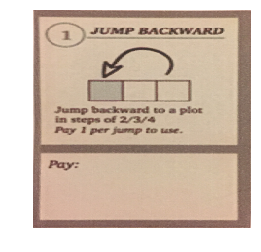

[1. 0. 0. 0.]


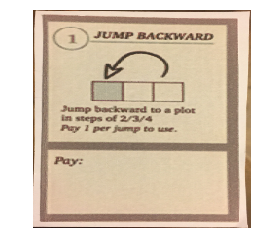

[1. 0. 0. 0.]


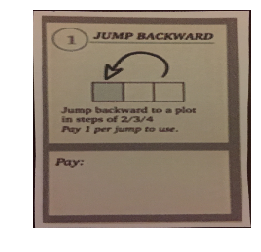

[1. 0. 0. 0.]


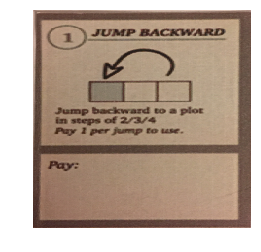

[1. 0. 0. 0.]


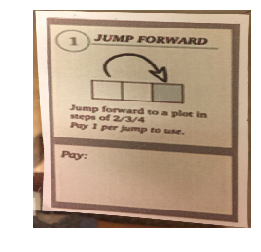

[0. 0. 0. 1.]


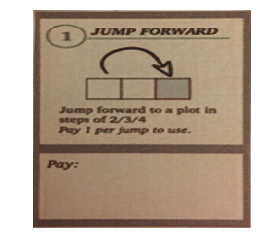

[0. 0. 0. 1.]


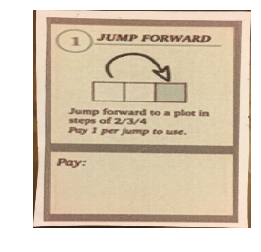

[0. 0. 0. 1.]


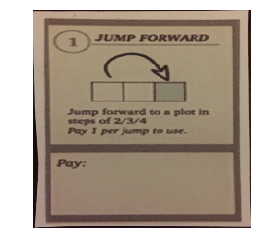

[0. 0. 0. 1.]


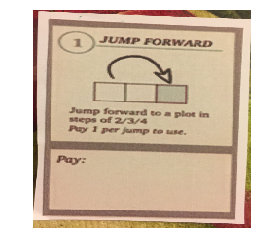

[0. 0. 0. 1.]


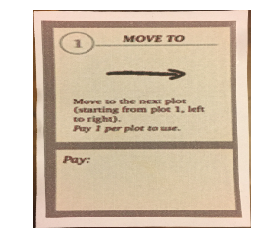

[0. 1. 0. 0.]


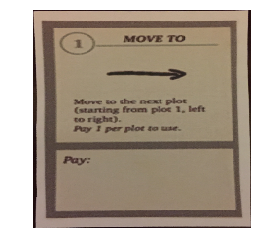

[0. 1. 0. 0.]


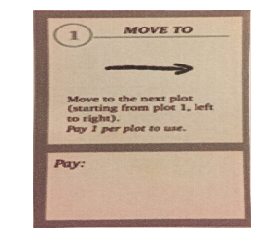

[0. 1. 0. 0.]


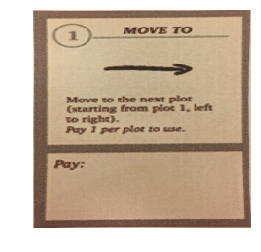

[0. 1. 0. 0.]


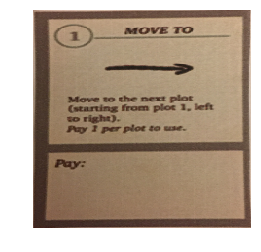

[0. 1. 0. 0.]


In [3]:
files = get_training_files()
training_data = list(get_training_data(data=files))
for image, label in training_data:
    plot_image(image)
    print(label)

Repurposed from https://github.com/keras-team/keras/blob/master/keras/applications/mobilenet.py

In [4]:
from keras.models import Model
from keras.layers import Input, Activation, Dropout, Reshape, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D
from keras import initializers, regularizers, constraints
from keras.utils import conv_utils
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K

def relu6(x):
    return K.relu(x, max_value=6)

class DepthwiseConv2D(Conv2D):
    """Depthwise separable 2D convolution.
    Depthwise Separable convolutions consists in performing
    just the first step in a depthwise spatial convolution
    (which acts on each input channel separately).
    The `depth_multiplier` argument controls how many
    output channels are generated per input channel in the depthwise step.
    # Arguments
        kernel_size: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
            Can be a single integer to specify the same value for
            all spatial dimensions.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
            Specifying any stride value != 1 is incompatible with specifying
            any `dilation_rate` value != 1.
        padding: one of `'valid'` or `'same'` (case-insensitive).
        depth_multiplier: The number of depthwise convolution output channels
            for each input channel.
            The total number of depthwise convolution output
            channels will be equal to `filters_in * depth_multiplier`.
        data_format: A string,
            one of `channels_last` (default) or `channels_first`.
            The ordering of the dimensions in the inputs.
            `channels_last` corresponds to inputs with shape
            `(batch, height, width, channels)` while `channels_first`
            corresponds to inputs with shape
            `(batch, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be 'channels_last'.
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you don't specify anything, no activation is applied
            (ie. 'linear' activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        depthwise_initializer: Initializer for the depthwise kernel matrix
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        depthwise_regularizer: Regularizer function applied to
            the depthwise kernel matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its 'activation').
            (see [regularizer](../regularizers.md)).
        depthwise_constraint: Constraint function applied to
            the depthwise kernel matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
    # Input shape
        4D tensor with shape:
        `[batch, channels, rows, cols]` if data_format='channels_first'
        or 4D tensor with shape:
        `[batch, rows, cols, channels]` if data_format='channels_last'.
    # Output shape
        4D tensor with shape:
        `[batch, filters, new_rows, new_cols]` if data_format='channels_first'
        or 4D tensor with shape:
        `[batch, new_rows, new_cols, filters]` if data_format='channels_last'.
        `rows` and `cols` values might have changed due to padding.
    """

    def __init__(self,
                 kernel_size,
                 strides=(1, 1),
                 padding='valid',
                 depth_multiplier=1,
                 data_format=None,
                 activation=None,
                 use_bias=True,
                 depthwise_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 depthwise_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 depthwise_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(DepthwiseConv2D, self).__init__(
            filters=None,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            activation=activation,
            use_bias=use_bias,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            bias_constraint=bias_constraint,
            **kwargs)
        self.depth_multiplier = depth_multiplier
        self.depthwise_initializer = initializers.get(depthwise_initializer)
        self.depthwise_regularizer = regularizers.get(depthwise_regularizer)
        self.depthwise_constraint = constraints.get(depthwise_constraint)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        if len(input_shape) < 4:
            raise ValueError('Inputs to `DepthwiseConv2D` should have rank 4. '
                             'Received input shape:', str(input_shape))
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = 3
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs to '
                             '`DepthwiseConv2D` '
                             'should be defined. Found `None`.')
        input_dim = int(input_shape[channel_axis])
        depthwise_kernel_shape = (self.kernel_size[0],
                                  self.kernel_size[1],
                                  input_dim,
                                  self.depth_multiplier)

        self.depthwise_kernel = self.add_weight(
            shape=depthwise_kernel_shape,
            initializer=self.depthwise_initializer,
            name='depthwise_kernel',
            regularizer=self.depthwise_regularizer,
            constraint=self.depthwise_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(input_dim * self.depth_multiplier,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs, training=None):
        outputs = K.depthwise_conv2d(
            inputs,
            self.depthwise_kernel,
            strides=self.strides,
            padding=self.padding,
            dilation_rate=self.dilation_rate,
            data_format=self.data_format)

        if self.bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)

        return outputs

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            rows = input_shape[2]
            cols = input_shape[3]
            out_filters = input_shape[1] * self.depth_multiplier
        elif self.data_format == 'channels_last':
            rows = input_shape[1]
            cols = input_shape[2]
            out_filters = input_shape[3] * self.depth_multiplier

        rows = conv_utils.conv_output_length(rows, self.kernel_size[0],
                                             self.padding,
                                             self.strides[0])
        cols = conv_utils.conv_output_length(cols, self.kernel_size[1],
                                             self.padding,
                                             self.strides[1])

        if self.data_format == 'channels_first':
            return (input_shape[0], out_filters, rows, cols)
        elif self.data_format == 'channels_last':
            return (input_shape[0], rows, cols, out_filters)

    def get_config(self):
        config = super(DepthwiseConv2D, self).get_config()
        config.pop('filters')
        config.pop('kernel_initializer')
        config.pop('kernel_regularizer')
        config.pop('kernel_constraint')
        config['depth_multiplier'] = self.depth_multiplier
        config['depthwise_initializer'] = initializers.serialize(self.depthwise_initializer)
        config['depthwise_regularizer'] = regularizers.serialize(self.depthwise_regularizer)
        config['depthwise_constraint'] = constraints.serialize(self.depthwise_constraint)
        return config

def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):
    """Adds an initial convolution layer (with batch normalization and relu6).
    # Arguments
        inputs: Input tensor of shape `(rows, cols, 3)`
            (with `channels_last` data format) or
            (3, rows, cols) (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 32.
            E.g. `(224, 224, 3)` would be one valid value.
        filters: Integer, the dimensionality of the output space
            (i.e. the number output of filters in the convolution).
        alpha: controls the width of the network.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
            Can be a single integer to specify the same value for
            all spatial dimensions.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
            Specifying any stride value != 1 is incompatible with specifying
            any `dilation_rate` value != 1.
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if data_format='channels_last'.
    # Output shape
        4D tensor with shape:
        `(samples, filters, new_rows, new_cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, new_rows, new_cols, filters)` if data_format='channels_last'.
        `rows` and `cols` values might have changed due to stride.
    # Returns
        Output tensor of block.
    """
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    filters = int(filters * alpha)
    x = Conv2D(filters, kernel,
               padding='same',
               use_bias=False,
               strides=strides,
               name='conv1')(inputs)
    x = BatchNormalization(axis=channel_axis, name='conv1_bn')(x)
    return Activation(relu6, name='conv1_relu')(x)


def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha,
                          depth_multiplier=1, strides=(1, 1), block_id=1):
    """Adds a depthwise convolution block.
    A depthwise convolution block consists of a depthwise conv,
    batch normalization, relu6, pointwise convolution,
    batch normalization and relu6 activation.
    # Arguments
        inputs: Input tensor of shape `(rows, cols, channels)`
            (with `channels_last` data format) or
            (channels, rows, cols) (with `channels_first` data format).
        pointwise_conv_filters: Integer, the dimensionality of the output space
            (i.e. the number output of filters in the pointwise convolution).
        alpha: controls the width of the network.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        depth_multiplier: The number of depthwise convolution output channels
            for each input channel.
            The total number of depthwise convolution output
            channels will be equal to `filters_in * depth_multiplier`.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
            Specifying any stride value != 1 is incompatible with specifying
            any `dilation_rate` value != 1.
        block_id: Integer, a unique identification designating the block number.
    # Input shape
        4D tensor with shape:
        `(batch, channels, rows, cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(batch, rows, cols, channels)` if data_format='channels_last'.
    # Output shape
        4D tensor with shape:
        `(batch, filters, new_rows, new_cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(batch, new_rows, new_cols, filters)` if data_format='channels_last'.
        `rows` and `cols` values might have changed due to stride.
    # Returns
        Output tensor of block.
    """
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    x = DepthwiseConv2D((3, 3),
                        padding='same',
                        depth_multiplier=depth_multiplier,
                        strides=strides,
                        use_bias=False,
                        name='conv_dw_%d' % block_id)(inputs)
    x = BatchNormalization(axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
    x = Activation(relu6, name='conv_dw_%d_relu' % block_id)(x)

    x = Conv2D(pointwise_conv_filters, (1, 1),
               padding='same',
               use_bias=False,
               strides=(1, 1),
               name='conv_pw_%d' % block_id)(x)
    x = BatchNormalization(axis=channel_axis, name='conv_pw_%d_bn' % block_id)(x)
    return Activation(relu6, name='conv_pw_%d_relu' % block_id)(x)

def MobileNet(input_shape=None,
              alpha=1.0,
              depth_multiplier=1,
              dropout=1e-3,
              input_tensor=None,
              pooling=None,
              classes=1000,
              weights_path=None):
    """Instantiates the MobileNet architecture.
    # Arguments
        alpha: controls the width of the network.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        depth_multiplier: depth multiplier for depthwise convolution
            (also called the resolution multiplier)
        dropout: dropout rate
        weights_path: path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of
            `layers.Input()`)
            to use as image input for the model.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
        is_learning: used to freeze the model for exporting to protobuf
            format.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
    """

    # Determine proper input shape and default size.
    if input_shape is None:
        default_size = 224
    else:
        rows = input_shape[0]
        cols = input_shape[1]

        if rows == cols and rows in [128, 160, 192, 224]:
            default_size = rows
        else:
            default_size = 224

    input_shape = (default_size, default_size, 3)

    row_axis, col_axis = (0, 1)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = _conv_block(img_input, 32, alpha, strides=(2, 2))
    x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)

    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier,
                              strides=(2, 2), block_id=2)
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)

    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier,
                              strides=(2, 2), block_id=4)
    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)

    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier,
                              strides=(2, 2), block_id=6)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)

    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier,
                              strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)

    shape = (1, 1, int(1024 * alpha))

    x = GlobalAveragePooling2D()(x)
    x = Reshape(shape, name='reshape_1')(x)
    x = Dropout(dropout, name='dropout')(x)
    x = Conv2D(classes, (1, 1),
               padding='same', name='conv_preds')(x)
    x = Activation('softmax', name='act_softmax')(x)
    x = Reshape((classes,), name='reshape_2')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = Model(inputs, x, name='mobilenet_%0.2f_%s' % (alpha, rows))

    if weights_path is not None:
        model.load_weights(weights_path)

    return model

Testing the model construct

In [5]:
# model = MobileNet()
# model.summary()

Training the model

In [6]:
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

def load_model(weights_path=None, classes=1000):
    return MobileNet(weights_path=weights_path, classes=classes)

def train_model(X_train=None,
                Y_train=None,
                X_test=None,
                Y_test=None,
                epochs=10,
                classes=1000,
                weights_path=None):
    if weights_path is None:
        weights_path = WEIGHTS_PATH

    print('Final model will be saved to: %s' % weights_path)
    
    if path.isfile(weights_path):
        model = load_model(weights_path=weights_path, classes=classes)
    else:
        model = load_model(weights_path=None, classes=classes)
    
    model.compile(optimizer='adam', 
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    batch_size = 32
    
    # Workaround for a tqdm issue
    # https://github.com/tqdm/tqdm/issues/481
    tqdm.monitor_interval = 0
    callbacks = [
        TensorBoard(log_dir=LOG_DIR,
            write_graph=True,
            write_images=True, 
            write_grads=True,
            batch_size=batch_size),
        ModelCheckpoint(CHECKPOINT_PATH, 
            monitor='loss', 
            verbose=1, 
            save_best_only=True, 
            mode='min',
            period=2),
        EarlyStopping(monitor='loss', 
            min_delta=0.0001, 
            patience=5, 
            verbose=1, 
            mode='auto'),
        TQDMNotebookCallback()
    ]
    
    if X_test is not None and Y_test is not None:
        validation_data = (X_test, Y_test)
    else:
        validation_data = None
        
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')
    
    datagen.fit(X_train)
    
    try:
        model.fit_generator(
            datagen.flow(X_train, Y_train, batch_size=32),
            validation_data=validation_data,
            steps_per_epoch=1000,
            epochs=epochs,
            callbacks=callbacks,
            verbose=0)
        model.save_weights(weights_path)

    except KeyboardInterrupt:
        model.save_weights(weights_path)

    return model

Exporting the model to Tensorflow protobuf format

In [7]:
from tensorflow.python.framework import graph_util, graph_io
import tensorflow as tf

def export_model(model, 
                 output_folder=None,
                 graphdef_file='graphdef.txt',
                 model_file='model.pb',
                 output_node_prefix='reshape_2'):
    K.set_learning_phase(0)
    sess = K.get_session()
    
    num_outputs = len(model.outputs)
    
    pred = [None]*num_outputs
    pred_node_names = [None]*num_outputs
    for i in range(num_outputs):
        pred_node_names[i] = output_node_prefix+str(i)
        pred[i] = tf.identity(model.outputs[i], name=pred_node_names[i])
    print('output nodes names: ', pred_node_names)
    
    graph = sess.graph
    graph_def = graph.as_graph_def()
    
    # Output the graph definition in ASCII
    tf.train.write_graph(graph_def, output_folder, graphdef_file, as_text=True)
    
    # Convert variables to constants
    constant_graph = graph_util.convert_variables_to_constants(sess, graph_def, pred_node_names)
    graph_io.write_graph(constant_graph, output_folder, model_file, as_text=False)

# Test training the model
Putting it all together

In [ ]:
X_train = []
Y_train = []
num_classes = len(files['classes'])
for image, label in training_data:
    X_train.append(image)
    Y_train.append(label)
X_train = np.array(X_train, dtype='float32')
Y_train = np.array(Y_train, dtype='float32')

train_model(X_train, Y_train, classes=num_classes)

Final model will be saved to: /Users/2359media/Documents/card-extractor/model_weights.h5


HBox(children=(IntProgress(value=0, description='Training', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1000), HTML(value='')))

In [ ]:
import json

with open(CLASSES_PATH, 'w') as classes_file:
    json.dump(files['classes'], classes_file, indent=4)

model = load_model(WEIGHTS_PATH, classes=num_classes)
model.summary()

In [10]:
model.save(FULL_MODEL_PATH)
export_model(model, output_folder=TF_MODEL_PATH)

output nodes names:  ['reshape_20']
INFO:tensorflow:Froze 137 variables.
Converted 137 variables to const ops.
